# **Monte Carlo con Políticas epsilon-soft**

    Author: Jaime Pujante Sáez
    Email: jaime.pujantes@um.es

    Author: Ricardo Javier Sendra Lázaro
    Email: ricardojavier.sendral@um.es

    Author: Pedro José Fernandez Campillo
    Email: pedrojose.fernandez1@um.es

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html

## **1. Preparación del Entorno**

In [2]:
#@title Importamos librerias
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym

import sys

sys.path.append('src')

print(sys.path)

from plotting import plot_episode_rewards, plot_len_episodes, render_episode, show_images_grid, plot_episode_proporcional_rewards
from agents import MonteCarloEpsilonGreedyAgent

['C:\\Users\\user\\AppData\\Local\\Programs\\Python\\Python313\\python313.zip', 'C:\\Users\\user\\AppData\\Local\\Programs\\Python\\Python313\\DLLs', 'C:\\Users\\user\\AppData\\Local\\Programs\\Python\\Python313\\Lib', 'C:\\Users\\user\\AppData\\Local\\Programs\\Python\\Python313', 'e:\\Proyectos personales Y cosiscas mias\\Trabajo-Uni\\MASTER\\EML\\RL_FCPSSL\\.venv', '', 'e:\\Proyectos personales Y cosiscas mias\\Trabajo-Uni\\MASTER\\EML\\RL_FCPSSL\\.venv\\Lib\\site-packages', 'e:\\Proyectos personales Y cosiscas mias\\Trabajo-Uni\\MASTER\\EML\\RL_FCPSSL\\.venv\\Lib\\site-packages\\win32', 'e:\\Proyectos personales Y cosiscas mias\\Trabajo-Uni\\MASTER\\EML\\RL_FCPSSL\\.venv\\Lib\\site-packages\\win32\\lib', 'e:\\Proyectos personales Y cosiscas mias\\Trabajo-Uni\\MASTER\\EML\\RL_FCPSSL\\.venv\\Lib\\site-packages\\Pythonwin', 'src']


In [3]:
#@title Importamos el lago helado
name = 'FrozenLake-v1'
env4 = gym.make(name, is_slippery=False, map_name="4x4", render_mode="rgb_array") # No resbaladizo para entender mejor los resultados.
env8 = gym.make(name, is_slippery=False, map_name="8x8", render_mode="rgb_array") # No resbaladizo para entender mejor los resultados.

## **2. Diseño del Agente**


### Estructura
Antes de pasar a explicar como se han implementado las politicas, cabe destacar la estructura de clases que se ha escogido para crear los agentes. En este sentido la estructura es la siguiente:

![alt text](docs/imgs/diagrama.png)

Nosotros vamos a centrarnos en el MonteCarlo y en una primera aproximacion a el entorno de Gymnasium. Estudios posteriores entraran mas en detalle en las distintas implementaciones de los algoritmos.


### Politica ε-greedy
Se ha redefinido la politica de ε-greedy. Esta politica ahora es implementada por la clase `src\agents\policies\epsilon_greedy.py`. En este caso concretamente estamos ante un algoritmo tabular, por lo que la funcion que va a usar es:
```python
def _get_tabular_action(self, state, info, Q, nA):
    """
    Selecciona una acción usando una política ε-greedy.
    
    Args:
        state: Estado actual del entorno.
        info: Información adicional del entorno.
        Q (np.array): Tabla de valores Q.
        nA (int): Número de acciones disponibles.
    
    Returns:
        int: Acción seleccionada.
    """
    if 'action_mask' in info:
        pi_A = info['action_mask'] * self.epsilon / np.sum(info['action_mask'])
        valid_actions = np.where(info['action_mask'])[0]
        best_action = valid_actions[np.argmax(Q[state, valid_actions])]
    else:
        pi_A = np.ones(nA, dtype=float) * self.epsilon / nA
        best_action = np.argmax(Q[state])
    
    pi_A[best_action] += (1.0 - self.epsilon)
    return np.random.choice(np.arange(nA), p=pi_A)


```

#### Claves sobre su Funcionamiento

La política **ε-greedy** asigna probabilidades a cada acción de la siguiente manera:


$$\pi(a | s) =
\begin{cases} 
1 - \epsilon + \frac{\epsilon}{|\mathcal{A}(s)|}, & \text{si } a = \arg\max_{a'} Q(s, a') \\
\frac{\epsilon}{|\mathcal{A}(s)|}, & \text{para } a \neq \arg\max_{a'} Q(s, a')
\end{cases}$$



Donde:
- $(Q(s, a))$ es el valor estimado de la acción $(a)$ en el estado $(s)$.
- $(\mathcal{A}(s))$ es el conjunto de acciones disponibles.


Ademas si el entorno tiene **Manejo de restricciones de acciones** quiere decir que el valor ```action_mask``` está presente (suele venir en el parametro info del entorno), se filtran las acciones válidas y se establecen las distribuciones de probabilidad.

### Politica $\pi$*

En este sentido como esta funcion es central a todos los agentes, pero concretamente en este caso a los agentes de metodos tabulares, por lo que hemos decidido que la implementará la clase padre de estos problemas. Se puede encontrar en `src\agents\tabular_methods\base.py`. El codigo aunque parecido al propuesto por el profesor ha sufrido algunas variaciones que comentaremos:
```python
def pi_star(self):
    """
    Devuelve la política óptima basada en la tabla Q aprendida.
    
    Returns:
        tuple: Matriz de política óptima y secuencia de acciones óptimas.
    """
    done = False
    pi_star = np.zeros([self.env.observation_space.n, self.env.action_space.n])
    state, info = self.env.reset(seed=self.seed)
    actions = []
    while not done:
        if 'action_mask' in info:
            valid_actions = np.where(info['action_mask'])[0]
            best_action = valid_actions[np.argmax(self.Q[state, valid_actions])]
        else:
            best_action = np.argmax(self.Q[state])
        actions.insert(0, best_action)
        pi_star[state, best_action] = 1
        state, reward, terminated, truncated, info = self.env.step(best_action)
        done = terminated or truncated
    return pi_star, actions

```

Como se puede observar se han establecido los mecanismos que al igual que en la funcion `_get_tabular_action` permiten evitar caer en estados invalidos segun lo indique o no el entorno en cuestion.

Aquí tienes la versión corregida y mejor estructurada de tu texto en **Markdown**:

---

## **Implementación del Agente**

El agente implementado para esta práctica es un **agente Monte Carlo on-policy**. Para permitir una mayor flexibilidad en la implementación de distintos agentes con diversas políticas, se han definido tres clases fundamentales:

---

### **1. Implementación de la Política**
Como se mencionó anteriormente, se ha creado una clase encargada de manejar la política del agente. En este caso, se ha implementado la estrategia **ε-greedy**, ubicada en `src\agents\policies\epsilon_greedy.py`.

Algunos aspectos clave de esta implementación son:

1. La función `get_action(self, state, info, Q=None, Q_function=None, action_space=None)` sirve como método genérico para cualquier implementación que la requiera, ya sea en **métodos aproximados** o, como en este caso, **tabulares**. La implementación específica de cada uno se puede consultar en el archivo mencionado.
2. La clase incorpora la funcionalidad de **decay** en los parámetros, si este ha sido establecido.
3. Se mantiene un **registro estadístico** de la evolución de los parámetros a lo largo del tiempo, lo que permite su consulta en caso de ser necesario.



### **2. Implementación del Método Monte Carlo**
El algoritmo de Monte Carlo está implementado en la clase `src\agents\tabular_methods\montecarlo\montecarlo_all.py`.

Esta clase define los dos métodos fundamentales de cualquier agente:

#### **2.1. Método `train()`**
El método `train()` es el encargado de iniciar el entrenamiento del agente. También incluye la opción de grabar videos (mediante la llamada a `super()`) en caso de que se requiera. Su implementación sigue la estructura estándar del algoritmo de Monte Carlo, como se explicó en las diapositivas de clase.

```python
def train(self, num_episodes, render_interval=-1, video_path=None):
    """
    Entrena el agente Monte Carlo. Configura la grabación de videos si es necesario.
    
    Args:
        num_episodes (int): Número de episodios de entrenamiento.
        render_interval (int, opcional): Frecuencia de grabación de episodios.
        video_path (str, opcional): Directorio donde almacenar videos.
    """
    super().train(num_episodes, render_interval, video_path)  # Configura video si es necesario
    
    state, info = self.env.reset(seed=self.seed)
    for episode in tqdm(range(num_episodes)):
        done = False
        episode_reward = 0
        episode_data = []
        while not done:
            action = self.get_action(state, info, self.Q, action_space=self.nA)
            next_state, reward, terminated, truncated, info = self.env.step(action)
            episode_data.append((state, action, reward))
            episode_reward += reward
            state = next_state
            done = terminated or truncated
        
        self.update(episode_data)  
        self.episode_rewards.append(episode_reward)  # Guarda recompensa acumulada
        self.episodes.append(episode_data)  # Guarda historial del episodio
        self.decay()
        state, info = self.env.reset(seed=self.seed)
```


#### **2.2. Método `update()`**
El método `update()` se ejecuta al final de cada episodio y es el encargado de actualizar los valores de la tabla \( Q \) utilizando el método **Monte Carlo de todas las visitas**. La actualización se realiza de la siguiente manera:

```python
def update(self, episode):
    """
    Actualiza los valores de Q usando el método Monte Carlo de todas las visitas.
    
    Args:
        episode (list): Lista de transiciones (estado, acción, recompensa).
    """
    G = 0  # Inicializamos el retorno acumulado
    for t in reversed(range(len(episode))):
        state, action, reward = episode[t]
        G = reward + self.gamma * G  # Aplicar descuento
        self.returns_counts[state, action] += 1
        n = self.returns_counts[state, action]
        self.Q[state, action] += (1/n) * (G - self.Q[state, action])  # Promedio incremental
```



## **3. Experimentación**

En esta sección, ejecutamos el algoritmo de **Monte Carlo con la política ε-soft** en los entornos de **FrozenLake 4x4 y 8x8** sin resbalar, con el objetivo de evaluar el desempeño del agente implementado. La configuracion del experimento será la siguiente:
- Se ejecutan **5000 episodios** de entrenamiento en cada entorno.
- Se guardan **videos cada 1000 episodios** para visualizar el progreso del agente.
- Se genera una **representación gráfica** de los valores estadisticos obtenidos con cada escenario.

   

### **3.1 Repressentaciones Gráficas**


En este escenario, para comprobar el aprendizaje del agente, se visualiza la evolución de la función:

$
f(t) = \frac{\sum_{i=1}^t R_i}{t}, \quad \text{para } t = 1,2,\dots, \text{Número de Episodios}
$

Esta función mide el **porcentaje de recompensas positivas obtenidas** a lo largo del tiempo. Dado que el retorno en el estado inicial es **1 (si llega a la meta) o 0 (si falla)**, el valor de \( f(t) \) representa la **tasa de éxito del agente** en alcanzar el estado terminal.

#### **Visualización del Proceso de Aprendizaje**

Para analizar el desempeño del agente, se han implementado distintas herramientas gráficas en el módulo `src\plotting\plotting.py`.

Las funciones clave incluidas en este módulo son:

1. **`plot_episode_rewards(list_stats)`**  
   - Muestra la evolución de la **proporción de recompensas** obtenidas durante el entrenamiento.
   - Permite visualizar cómo mejora la tasa de éxito del agente con el tiempo.
   
   ```python
    def plot_episode_rewards(list_stats, smoothing_window=50):
        indices = np.arange(len(list_stats))
        if smoothing_window > 1:
            smoothed_rewards = np.convolve(list_stats, np.ones(smoothing_window) / smoothing_window, mode='valid')
            indices = indices[:len(smoothed_rewards)]
        else:
            smoothed_rewards = list_stats
        plt.figure(figsize=(8, 4))
        plt.plot(indices, smoothed_rewards, label="Recompensas por Episodio", color='b')
        plt.title('Recompensas por Episodio (Suavizado)')
        plt.xlabel('Episodio')
        plt.ylabel('Recompensa')
        plt.legend()
        plt.grid(True)
        plt.show()
   ```

2. **`plot_len_episodes(episodes)`**  
   - Genera una gráfica que representa la **longitud de los episodios**, es decir, el número de pasos requeridos para alcanzar la meta en cada episodio.
   - Incluye una **curva de tendencia** para analizar el comportamiento a lo largo del entrenamiento.
   
   ```python
    def plot_len_episodes(episodes, smoothing_window=50):
        episode_lengths = [len(episode) for episode in episodes]
        indices = np.arange(len(episode_lengths))
        if smoothing_window > 1:
            smoothed_lengths = np.convolve(episode_lengths, np.ones(smoothing_window) / smoothing_window, mode='valid')
            indices = indices[:len(smoothed_lengths)]
        else:
            smoothed_lengths = episode_lengths
        plt.figure(figsize=(8, 4))
        plt.plot(indices, smoothed_lengths, label="Longitud de Episodio", color='b')
        plt.title('Longitud de Episodios por T (Suavizado)')
        plt.xlabel('Episodio T')
        plt.ylabel('Número de Pasos')
        plt.legend()
        plt.grid(True)
        plt.show()
   ```

3. **`plot_episode_proporcional_rewards(list_stats, smoothing_window=50)`**  
   - Calcula y muestra la evolución de la **proporción acumulada de recompensas** a lo largo del entrenamiento.
   - Usa **una media móvil opcional** para suavizar la curva y mejorar la interpretación.
   
   ```python
   def plot_episode_proporcional_rewards(list_stats, smoothing_window=50):
       indices = np.arange(len(list_stats))
       proporciones = np.cumsum(list_stats) / (indices + 1)

       if smoothing_window > 1:
           smoothed_rewards = np.convolve(proporciones, np.ones(smoothing_window) / smoothing_window, mode='valid')
           indices = indices[:len(smoothed_rewards)]
       else:
           smoothed_rewards = proporciones

       plt.figure(figsize=(8, 4))
       plt.plot(indices, smoothed_rewards, label="Proporción de Recompensas", color='b')
       plt.title('Proporción Acumulada de Recompensas')
       plt.xlabel('Episodio')
       plt.ylabel('Proporción de éxitos')
       plt.legend()
       plt.grid(True)
       plt.show()
   ```

4. **`render_episode(actions_to_take, env)`**  
   - Permite visualizar la ejecución del agente paso a paso en el entorno.
   - Útil para **inspeccionar visualmente** la estrategia aprendida por el agente.


In [4]:
n_episodes = 5000



### **3.2 Experimentación en el escenario 4x4**

En esta sección se ejecutará el **agente Monte Carlo con política ε-greedy** en el entorno **FrozenLake 4x4**.

#### **Configuración del experimento**
Se utilizará el siguiente código para entrenar el agente:

```python
agent = MonteCarloEpsilonGreedyAgent(env4, epsilon=0.4, epsilon_decay=1)
agent.train(n_episodes, render_interval=500, video_path='videos')
stats = agent.stats()
```

Los parámetros utilizados son:
- **`env4`**: Entorno de **FrozenLake 4x4**, donde el agente debe aprender a llegar a la meta sin caer en los agujeros.
- **`epsilon=0.4`**: Se establece un nivel de exploración inicial moderado para permitir al agente probar diferentes caminos antes de consolidar una estrategia óptima.
- **`epsilon_decay=1`**: No se aplica reducción progresiva de ε, manteniendo la tasa de exploración constante durante todo el entrenamiento.
- **`n_episodes`**: Número total de episodios de entrenamiento.
- **`render_interval=500`**: Se generará una visualización del agente cada 500 episodios para analizar su evolución.
- **`video_path='videos'`**: Se guardarán los videos de las ejecuciones en la carpeta `videos/`.

#### **Resultados esperados**
Tras el entrenamiento, se extraerán estadísticas con:

```python
stats = agent.stats()
```


In [5]:

agent = MonteCarloEpsilonGreedyAgent(env4, epsilon=0.4, epsilon_decay=1)
agent.train(n_episodes, render_interval=500, video_path='videos')
stats = agent.stats()


e:\Proyectos personales Y cosiscas mias\Trabajo-Uni\MASTER\EML\RL_FCPSSL\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at e:\Proyectos personales Y cosiscas mias\Trabajo-Uni\MASTER\EML\RL_FCPSSL\videos\FrozenLake-v1\MonteCarloEpsilonGreedyAgent(gamma0.99_epsilon0.4_epsilon_decay1_min_epsilon0.01) folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 5000/5000 [00:02<00:00, 1854.64it/s]


Ahora podemos ver las diferentes graficas de los estadisticos del agente. Ademas si queremos podemos mostrar los videos que se encuentran en la carpeta creada `videos\FrozenLake-v1\MonteCarloEpsilonGreedyAgent(gamma0.99_epsilon0.4_epsilon_decay1_min_epsilon0.01)`

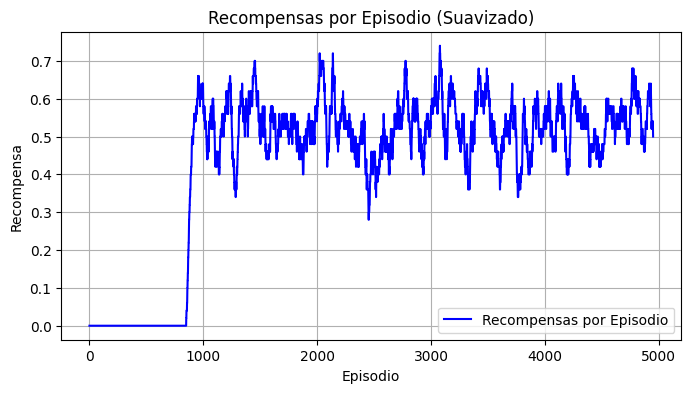

In [6]:
plot_episode_rewards(stats["episode_rewards"])

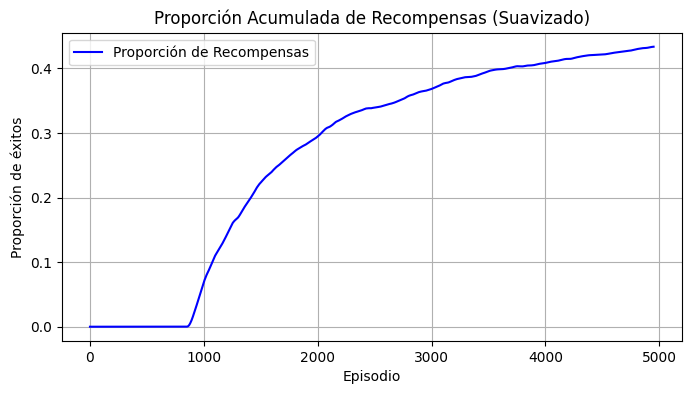

In [7]:
plot_episode_proporcional_rewards(stats["episode_rewards"])

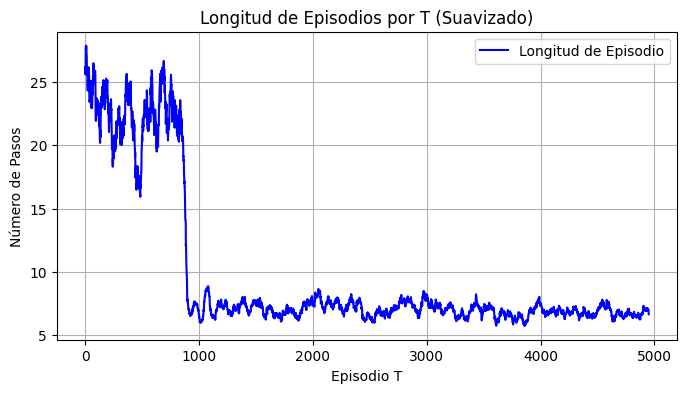

In [8]:
plot_len_episodes(stats["episodes"])

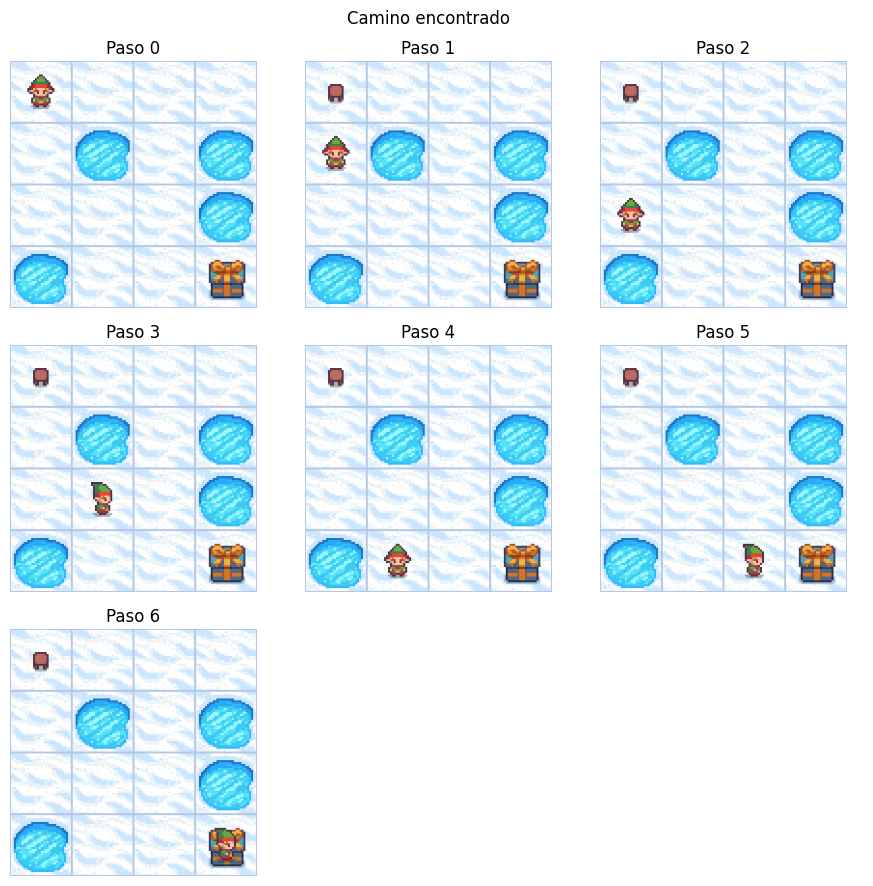

In [9]:
render_episode(agent.pi_star()[1], env4, seed=32)

### **3.3 Experimentación en el escenario 8x8**
Para este escenario tendremos la misma configuracion que el experimento anterior


In [10]:
agent = MonteCarloEpsilonGreedyAgent(env8, epsilon=0.4, epsilon_decay=1)
agent.train(n_episodes, render_interval=500, video_path='videos')
stats = agent.stats()

100%|██████████| 5000/5000 [00:19<00:00, 252.38it/s]


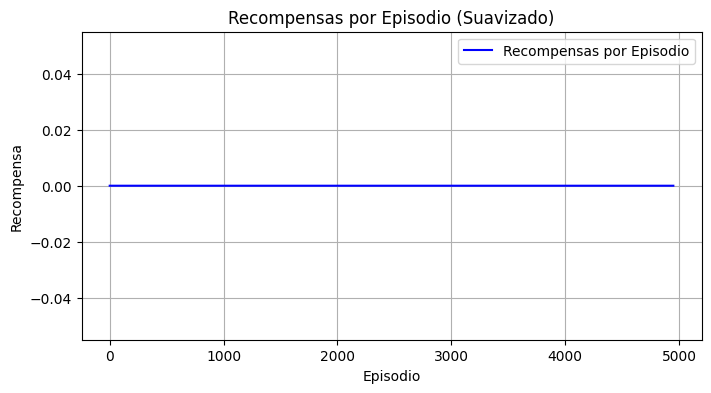

In [11]:
plot_episode_rewards(stats["episode_rewards"])

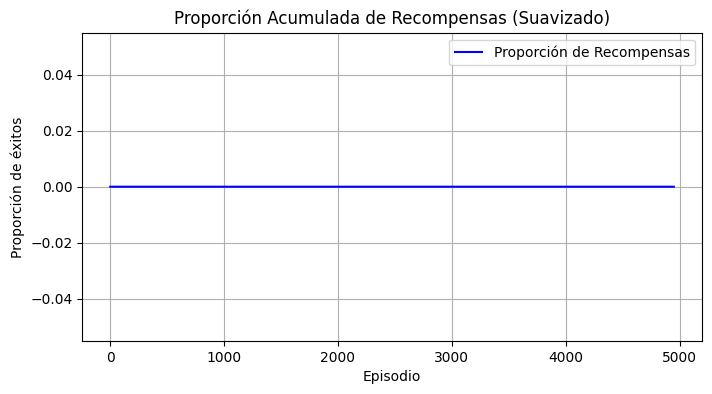

In [12]:
plot_episode_proporcional_rewards(stats["episode_rewards"])

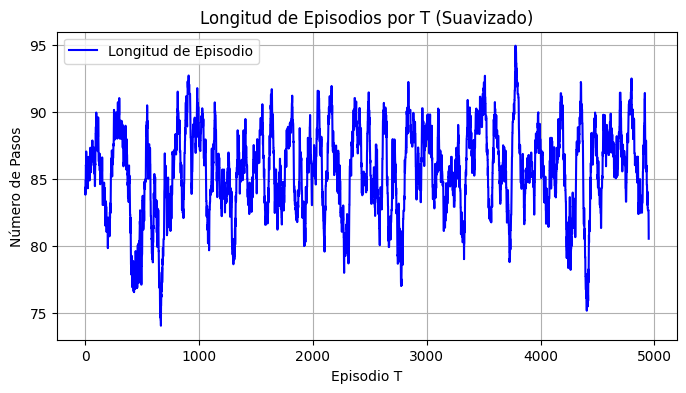

In [13]:
plot_len_episodes(stats["episodes"])

Como se puede observar usando los mismos parametros no obtenemos un buen resultado por lo que conviene que se cambien los ajustes, en ese caso vamos a probar con un decay y empezando con la exploracion al maximo.

In [14]:
agent = MonteCarloEpsilonGreedyAgent(env8, epsilon=1, epsilon_decay=0.99995)
agent.train(n_episodes, render_interval=500, video_path='videos')
stats = agent.stats()

e:\Proyectos personales Y cosiscas mias\Trabajo-Uni\MASTER\EML\RL_FCPSSL\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
e:\Proyectos personales Y cosiscas mias\Trabajo-Uni\MASTER\EML\RL_FCPSSL\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at e:\Proyectos personales Y cosiscas mias\Trabajo-Uni\MASTER\EML\RL_FCPSSL\videos\FrozenLake-v1\MonteCarloEpsilonGreedyAgent(gamma0.99_epsilon1_epsilon_decay0.99995_min_epsilon0.01) folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 5000/5000 [00:08<00:00, 600.45it/s]


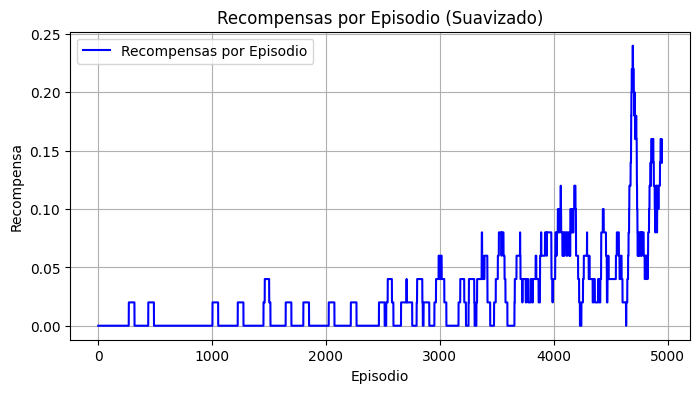

In [15]:
plot_episode_rewards(stats["episode_rewards"])

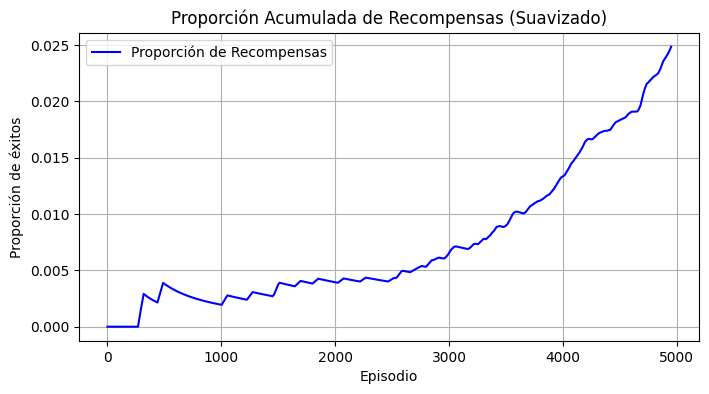

In [16]:
plot_episode_proporcional_rewards(stats["episode_rewards"])

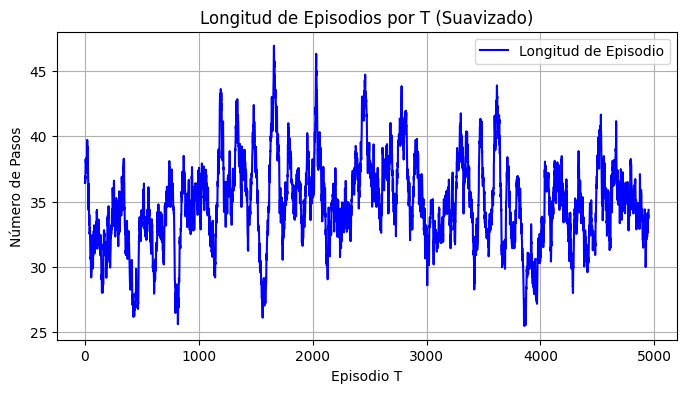

In [17]:
plot_len_episodes(stats["episodes"])

Como podemos ver esta vez parece que encuentra un camino, por lo que vamos a ver cual es el que esta encontrando:

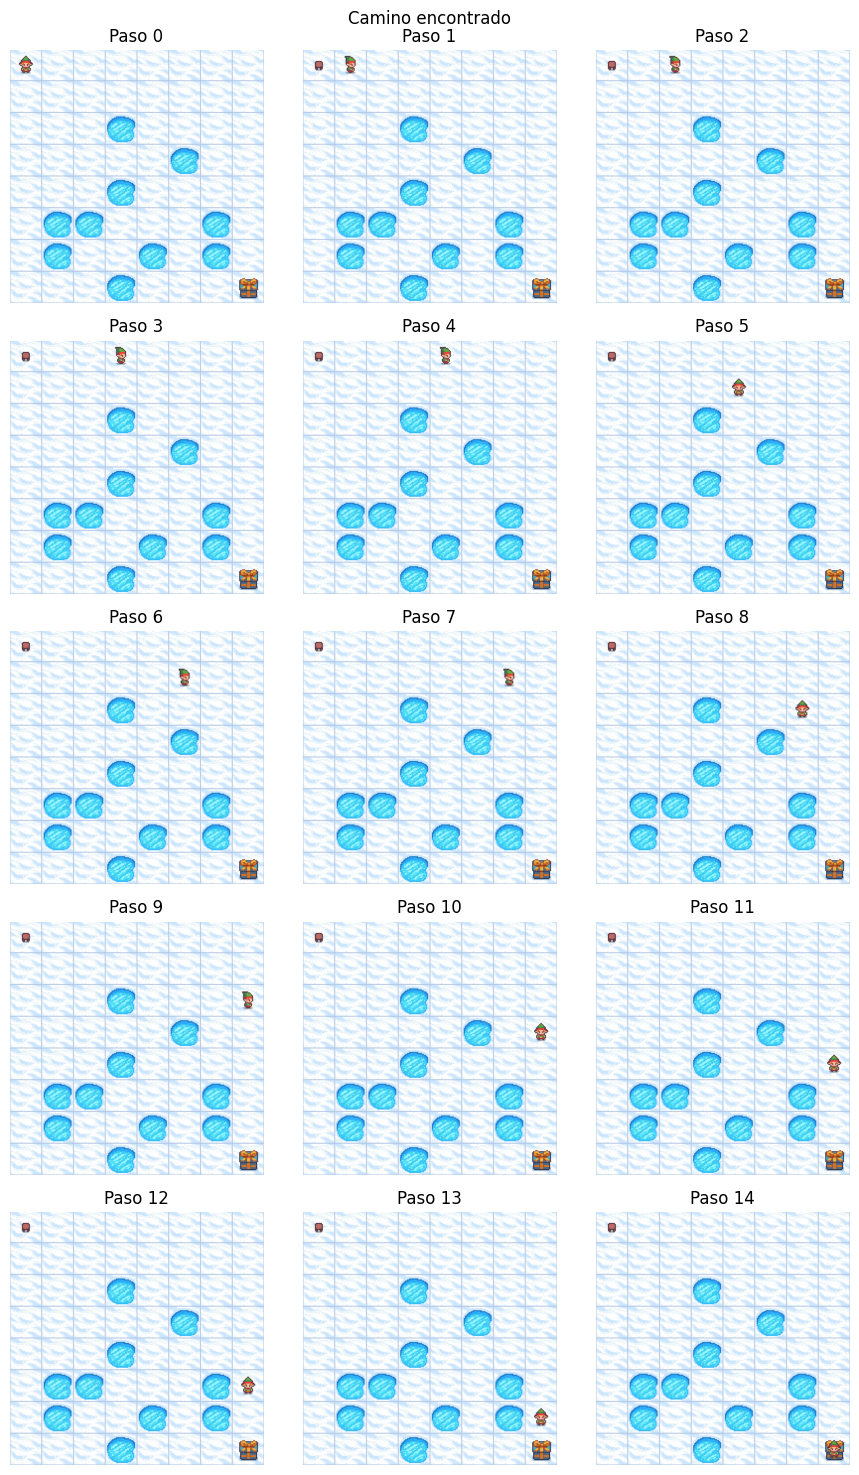

In [19]:
render_episode(agent.pi_star()[1], env8, seed=32)


## **4. Análisis y Estudios Futuros**

### **4.1 Análisis de Resultados**

- En el entorno **4x4**, el agente mejora gradualmente su rendimiento a medida que avanza en los episodios. La gráfica de proporción de recompensas muestra un incremento progresivo, lo que indica que el agente está aprendiendo a evitar los estados que llevan a fallos y a dirigirse hacia la meta de manera más eficiente.
- En el entorno **8x8**, el aprendizaje es más lento debido a la complejidad del entorno y el mayor número de estados posibles. Sin embargo, los resultados sugieren que el agente **ha comenzado a encontrar una política óptima**, aunque aún requiere más exploración y entrenamiento para converger completamente a ella.
- Se observa que en el entorno **4x4**, la política obtenida es más estable, mientras que en **8x8**, aunque el agente aprende, las decisiones pueden ser más erráticas debido a la dificultad del problema.
- Las gráficas de la **longitud de los episodios** reflejan que, con el tiempo, el agente tiende a encontrar trayectorias más cortas hacia la meta, optimizando así su toma de decisiones.
- Se ha representado visualmente el camino seguido por el agente tras el aprendizaje, mostrando cómo ha aprendido a navegar por el entorno.
- **Configuración de $\epsilon$ y su tasa de decaimiento**: Se ha comprobado que la correcta elección de estos parámetros es **crítica** para el aprendizaje del agente. En particular, la configuración de **$\epsilon=0.4$ sin decaimiento** en el entorno **8x8** ha mostrado que, aunque el agente comienza a aprender, su exploración no es suficiente para garantizar una convergencia óptima. Este experimento refuerza la idea de que un **buen balance entre exploración y explotación** es clave en problemas más complejos.

### **4.2 Conclusiones**

Este notebook ha permitido demostrar la capacidad del **Método de Monte Carlo On-Policy implementado** para aprender a través de la exploración y la actualización basada en episodios completos. Se ha comentado la implementación del agente y la estructura base para implementar otros agentes, ademas para seguir la linea de lo indicado por el profesor, se ha analizado su rendimiento en diferentes escenarios.
A partir de los resultados obtenidos, podemos concluir que:
1. El método de Monte Carlo es efectivo para la toma de decisiones basada en experiencias pasadas, aunque dependiendo del entorno y del problema, puede requerir un número alto de episodios para lograr una convergencia estable.
2. En escenarios más complejos, el aprendizaje es más lento, pero aún así es capaz de mejorar su rendimiento con el tiempo.
3. La correcta elección de hiperparámetros, como **$\epsilon$**, el número de episodios y la estrategia de actualización, influye en la calidad del aprendizaje del agente.
4. **El entorno 8x8 ha mostrado signos de mejora, pero requiere mayor explotación para converger a la política óptima**. Ajustar la tasa de decaimiento de **$\epsilon$** podría ser clave para alcanzar una estrategia más efectiva en menos episodios.

En los siguientes notebooks, se continuará el estudio explorando diferentes hiperparámetros y estrategias de aprendizaje, como la variación de **$\gamma$** y el impacto del decaimiento de **$\epsilon$** en el rendimiento del agente además de otros métodos.
